# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [ ]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google-colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1rxgk3e9O4doAoEFN3BeZqKULqGl7j6yV'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Device #1.csv')   # Device #1

id = '1YXc02xvqULO0uUP7xcb4W84SV6RxruoN'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Device #2.csv')   # Device #2

id = '1NZL4v46VhdSKmF2NKAYdWIQ0yGmh4Aic'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Device #3.csv')   # Device #3

id = '1izH8XwPLYgvy6h1BLM8gwCqVntgwYsvq'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Device #4.csv')   # Device #4

id = '115ev199YrX-Jqf0TbbibebABPKPxtffg'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Device #5.csv')   # Device #5

In [3]:
# load data
d1 = pd.read_csv('/content/Device #1.csv')
d2 = pd.read_csv('/content/Device #2.csv')
d3 = pd.read_csv('/content/Device #3.csv')
d4 = pd.read_csv('/content/Device #4.csv')
d5 = pd.read_csv('/content/Device #5.csv')
d1.shape, d2.shape, d3.shape, d4.shape, d5.shape, d6.shape, d7.shape, d8.shape, d9.shap

((1018298, 117),
 (835876, 117),
 (355500, 117),
 (1098677, 117),
 (828260, 117),
 (836891, 117),
 (375222, 117),
 (863056, 117),
 (414622, 117))

In [3]:
#Read dataset
df = pd.read_csv('https://tinyurl.com/vrv62fzc') 
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
df.Label.value_counts()

BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: Label, dtype: int64

In [5]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [8]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
df.Label.value_counts()

0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: Label, dtype: int64

In [11]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==6)|(df['Label']==1)|(df['Label']==4)]
df_major = df.drop(df_minor.index)

X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

klabel=kmeans.labels_
df_major['klabel']=klabel

df_major['klabel'].value_counts()

cols = list(df_major)
cols.insert(78, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

df_major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
0,-0.528470,-0.068426,-0.081806,-0.032573,-0.048343,-0.202326,-0.085798,-0.141625,-0.176448,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,133,0
1,-0.524593,0.704878,0.850340,0.027749,0.920410,0.603275,-0.211174,-0.082434,0.240596,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
2,-0.525233,0.300651,0.339163,0.020443,0.363712,0.603275,-0.211174,0.044064,0.439619,0.484295,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,682,0
3,-0.524560,0.652153,0.745098,0.026625,0.933533,0.603275,-0.211174,-0.074097,0.257378,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
4,-0.524555,0.757604,0.805237,0.028030,0.960037,0.603275,-0.211174,-0.091861,0.225734,1.006302,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,-0.528463,-0.068426,-0.051737,-0.031309,-0.046220,-0.200831,0.457498,-0.064078,-0.255104,-0.517901,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,851,0
56657,-0.524840,-0.068426,-0.051737,-0.029904,-0.043932,-0.178412,0.770939,0.022086,-0.255104,-0.472838,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,976,0
56658,-0.215111,-0.015701,-0.021667,-0.013231,-0.016083,0.423920,-0.211174,0.269089,0.640328,0.711051,...,-0.108682,-0.081786,-0.127669,-0.093554,-0.256386,-0.137651,-0.269448,-0.238252,352,3
56659,-0.215111,0.037025,0.008402,-0.014823,0.058109,0.373103,-0.211174,0.050807,0.399311,1.528310,...,-0.108677,-0.081786,-0.127664,-0.093548,-0.256402,-0.137651,-0.269464,-0.238268,980,3


In [12]:

def typicalSampling(group):
    name = group.name
    frac = 0.008
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

result['Label'].value_counts()

0    114
3    105
5     60
2     22
Name: Label, dtype: int64

In [13]:
result

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
5635,-0.421157,-0.033276,-0.081806,-0.033182,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,2,3
25182,-0.528464,-0.068426,-0.051737,-0.030278,-0.046531,-0.184390,0.687355,-0.000891,-0.255104,-0.524030,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,9,0
745,-0.507000,-0.050851,0.008402,-0.033088,0.057826,-0.218767,-0.211174,-0.198110,-0.209439,1.019281,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
1501,-0.508440,-0.050851,0.008402,-0.033088,0.057826,-0.218767,-0.211174,-0.198110,-0.209439,1.019281,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,10,3
12205,-0.528468,-0.086001,-0.066771,-0.034306,-0.048288,-0.248659,-0.211174,-0.247894,-0.255104,-0.557556,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52463,-0.528442,-0.015701,-0.081806,-0.034306,-0.048343,-0.248659,-0.211174,-0.247894,-0.255104,-0.559719,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,983,3
44504,2.183831,0.001874,-0.006633,-0.018336,0.057771,0.261006,-0.211174,0.078571,0.364314,3.094331,...,-0.108543,-0.081786,-0.127559,-0.093403,2.636937,-0.137651,2.547366,2.675989,984,3
31937,-0.527820,-0.086001,-0.066771,-0.032105,-0.047657,-0.178412,0.770939,0.022086,-0.255104,-0.532682,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,987,0
53350,-0.525891,-0.086001,-0.066771,-0.032011,-0.047318,-0.175423,0.812731,0.033575,-0.255104,-0.519343,...,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,989,0


# Data Pre-processing

In [4]:
def pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign'] 
    benign = benign.drop('type',1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign']
    abnormal = abnormal.drop('type',1)
    abnormal['type'] = 1

    # split benign data evenly to three parts
    benign_train, benign_tr, benign_test = np.split(benign, [int((1/3)*len(benign)), int((2/3)*len(benign))])
    benign_test_mix = benign_test.copy()    # with label 116

    train_label = benign_train['type']

    benign_train = benign_train.drop('type',axis=1)
    benign_tr = benign_tr.drop('type',axis=1)

    # Create Mix data
    abnormal_sample = abnormal.sample(frac = 1)             
    mix_temp = pd.concat([benign_test_mix, abnormal_sample]) 
    mix_temp = shuffle(mix_temp, random_state=1)  

    mix = mix_temp.copy()                  
    mix_data = mix_temp.drop('type',axis=1) 
    mix_label = mix['type']

    scaler = StandardScaler()
    benign_train = scaler.fit_transform(benign_train) 
    benign_tr = scaler.transform(benign_tr)          
    mix_data = scaler.transform(mix_data)            

    # keep benign_train as original form here --> for later use
    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)  
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)    
    mix_label = torch.tensor(np.array(mix_label))

    return benign_train, benign_tr, mix_data, mix_label

In [5]:
def other_pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign'] 
    benign = benign.drop('type',1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign']
    abnormal = abnormal.drop('type',1)
    abnormal['type'] = 1

    # split benign data to two parts
    benign_tr, benign_test = train_test_split(benign, test_size = 0.2, random_state = 5703)
    benign_tr = benign_tr.drop('type',axis=1)

    # Create Mix data
    abnormal_sample = abnormal.sample(frac = 1)           
    mix_temp = pd.concat([benign_test, abnormal_sample])  
    mix_temp = shuffle(mix_temp, random_state=1)         

    mix = mix_temp.copy()                   
    mix_data = mix_temp.drop('type',axis=1) 
    mix_label = mix['type']

    # Standardisation
    scaler = StandardScaler()
    benign_tr = scaler.fit_transform(benign_tr)        
    mix_data = scaler.transform(mix_data) 

    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)  
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)   
    mix_label = torch.tensor(np.array(mix_label))                       

    return benign_tr, mix_data, mix_label

In [6]:
# for Federated Model training
benign_train_1, benign_tr_1, mix_data_1, mix_label_1 = pre_processing(d1)
benign_train_2, benign_tr_2, mix_data_2, mix_label_2 = pre_processing(d2)
benign_train_3, benign_tr_3, mix_data_3, mix_label_3 = pre_processing(d3)
benign_train_4, benign_tr_4, mix_data_4, mix_label_4 = pre_processing(d4)
benign_train_5, benign_tr_5, mix_data_5, mix_label_5 = pre_processing(d5)

## LSTM approach for client dataset modelling

In [ ]:
import tensorflow as tf
import tensorflow_federated as tff

# Define the input shape for the model
input_shape = (None, 10, 1)

# Define the LSTM model architecture
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape[1:], return_sequences=True),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Define the TFF type representing a single client's data
input_type = tff.TensorType(tf.float32, shape=input_shape)

# Define the TFF type representing a batch of client data
batch_type = tff.NamedTupleType([('x', input_type), ('y', input_type)])

# Define the loss function for the model
def loss(model, batch):
    y_pred = model(batch.x)
    return tf.keras.losses.binary_crossentropy(batch.y, y_pred)

# Define the evaluation metric for the model
def accuracy(model, batch):
    y_pred = model(batch.x)
    return tf.keras.metrics.binary_accuracy(batch.y, y_pred)

# Define the TFF type representing a federated dataset
def create_dataset():
    return [tf.data.Dataset.from_tensor_slices({
        'x': tf.random.normal([10, 1]),
        'y': tf.random.uniform([1], minval=0, maxval=2, dtype=tf.int32)
    }).batch(2) for _ in range(10)]

# Define the TFF learning algorithm
fed_avg = tff.learning.build_federated_averaging_process(
    model_fn=create_model,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1))

# Define the TFF simulation configuration
iterative_process = fed_avg.initialize()
for round_num in range(10):
    sampled_clients = tff.simulation.select_random_clients(
        create_dataset(), num_clients=2)
    federated_dataset = [create_dataset()[i] for i in sampled_clients]
    iterative_process = fed_avg.next(iterative_process, federated_dataset)
    train_metrics = tff.learning.metrics.federated_mean(
        iterative_process.next_state.metrics['train'])
    print(f'Round {round_num}: {train_metrics}')


       Round 0: {binary_accuracy: 0.485, loss: 0.698}
       Round 1: {binary_accuracy: 0.515, loss: 0.694}
       Round 2: {binary_accuracy: 0.535, loss: 0.689}
       Round 3: {binary_accuracy: 0.485, loss: 0.688}
       Round 4: {binary_accuracy: 0.555, loss: 0.684}
       Round 5: {binary_accuracy: 0.535, loss: 0.677}
       Round 6: {binary_accuracy: 0.555, loss: 0.673}
       Round 7: {binary_accuracy: 0.575, loss: 0.665}
       Round 8: {binary_accuracy: 0.59, loss: 0.659}
       Round 9: {binary_accuracy: 0.575, loss: 0.653}


# re-Training and Testing

## Parameters Setting

In [8]:
num_clients = 9      # Number of clients
num_selected = 3     # Typically, num_selected is around 30–40% of the num_clients.
batch_size = 128
baseline_num = 1000  # choose some data from the train set to retrain the data from trained model 
num_rounds = 3#100      # Total number of communication rounds for the global model to train.
epochs = 5          # for train client model
retrain_epochs = 5  # Total number of retraining rounds on the global server after receiving the model weights 
                      # from all the clients that participated in the communication round.

## Retraining Mechanism

In [9]:

def baseline_data(size = baseline_num, batch_size = batch_size): # baseline_num
    rng = np.random.default_rng()
    x_1 = rng.choice(benign_train_1, size=size, replace = True, shuffle = True, axis=0) # [[[[[[randomly select]]]]]] 
    x_2 = rng.choice(benign_train_2, size=size, replace = True, shuffle = True, axis=0)
    x_3 = rng.choice(benign_train_3, size=size, replace = True, shuffle = True, axis=0)
    x_4 = rng.choice(benign_train_4, size=size, replace = True, shuffle = True, axis=0)
    x_5 = rng.choice(benign_train_5, size=size, replace = True, shuffle = True, axis=0)
    x_6 = rng.choice(benign_train_6, size=size, replace = True, shuffle = True, axis=0)
    x_7 = rng.choice(benign_train_7, size=size, replace = True, shuffle = True, axis=0)
    x_8 = rng.choice(benign_train_8, size=size, replace = True, shuffle = True, axis=0)
    x_9 = rng.choice(benign_train_9, size=size, replace = True, shuffle = True, axis=0)


    loader_1 = torch.utils.data.DataLoader(x_1, batch_size=batch_size)
    loader_2 = torch.utils.data.DataLoader(x_2, batch_size=batch_size)
    loader_3 = torch.utils.data.DataLoader(x_3, batch_size=batch_size)
    loader_4 = torch.utils.data.DataLoader(x_4, batch_size=batch_size)
    loader_5 = torch.utils.data.DataLoader(x_5, batch_size=batch_size)
    loader_6 = torch.utils.data.DataLoader(x_6, batch_size=batch_size)
    loader_7 = torch.utils.data.DataLoader(x_7, batch_size=batch_size)
    loader_8 = torch.utils.data.DataLoader(x_8, batch_size=batch_size)
    loader_9 = torch.utils.data.DataLoader(x_9, batch_size=batch_size)

    loaders = {'D1': loader_1,
               'D2': loader_2,
               'D3': loader_3,
               'D4': loader_4,
               'D5': loader_5,
               'D6': loader_6,
               'D7': loader_7,
               'D8': loader_8,
               'D9': loader_9}

    return loaders

## FedAvg

In [10]:

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * 
                                       (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict()
    temp = copy.deepcopy(global_dict)     
    v = {x:1 for x in copy.deepcopy(global_dict)}   

    for i,k in enumerate(global_dict.keys()): 
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) 
                               for i in range(len(client_models))], 0).mean(0)
       temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias
        


## Utilities

In [11]:

def train_data_loaders(batch_size = batch_size):
    data_1 = torch.utils.data.DataLoader(benign_train_1, batch_size = batch_size, shuffle=True)
    data_2 = torch.utils.data.DataLoader(benign_train_2, batch_size = batch_size, shuffle=True)
    data_3 = torch.utils.data.DataLoader(benign_train_3, batch_size = batch_size, shuffle=True)
    data_4 = torch.utils.data.DataLoader(benign_train_4, batch_size = batch_size, shuffle=True)
    data_5 = torch.utils.data.DataLoader(benign_train_5, batch_size = batch_size, shuffle=True)
    data_6 = torch.utils.data.DataLoader(benign_train_6, batch_size = batch_size, shuffle=True)
    data_7 = torch.utils.data.DataLoader(benign_train_7, batch_size = batch_size, shuffle=True)
    data_8 = torch.utils.data.DataLoader(benign_train_8, batch_size = batch_size, shuffle=True)
    data_9 = torch.utils.data.DataLoader(benign_train_9, batch_size = batch_size, shuffle=True)

    client_loaders = {'D1': data_1,
                      'D2': data_2,
                      'D3': data_3,
                      'D4': data_4,
                      'D5': data_5,
                      'D6': data_6,
                      'D7': data_7,
                      'D8': data_8,
                      'D9': data_9}

    return client_loaders

In [12]:

def client_update(client_model, optimizer, train_data, epoch=3):
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for bx, (data) in enumerate(train_data):
            output = client_model(data.float()) # tensor 115
            optimizer.zero_grad()
            # criterion = nn.MSELoss(reduction='mean')
            # loss = criterion(data.to(device), output)
            loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
            loss.backward()
            optimizer.step()
            # print(loss.item())
            running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())


## Deep Auto-encoder Model

In [13]:
# Deep Auto-encoder model

input_dim = 115
class AEModel(nn.Module):
    def __init__(self):
        super(AEModel,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.25*input_dim)),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(int(0.25*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(input_dim)),
            nn.Tanh(),
        )
    def forward(self, x):
        encode = self.encoder(x)
        decoder = self.decoder(encode)
        return decoder

## Initialisation

In [14]:
global_model = AEModel().to(device)
client_models = [AEModel().to(device) for _ in range(num_selected)] # part or all clients

for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]

In [15]:
baseline_data = baseline_data()
train_loader = train_data_loaders() 
devices = ['D1','D2','D3','D4','D5','D6','D7','D8','D9']

# Training Federated Model and gauging packet loss due to intrusion

In [16]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    client_idx = np.random.permutation(num_clients)[:num_selected]
    print('client_idx: ',client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] 

    loss = 0
    for i in tqdm(range(num_selected)):
        client_syn(client_models[i], global_model)
        loss += client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
    train_loss_client.append(loss)


    loss_retrain = 0
    for i in tqdm(range(num_selected)): 
        loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    train_loss_global.append(loss_retrain/num_selected)

    server_aggregate_M(global_model, client_models, client_lens)

    print("\nclient_loss: ", loss)
    print('global_loss: ', loss_retrain/num_selected)

torch.save(global_model,'global.pt')

time_required = time.time() - start_time
print('\nTIME: {}mins'.format(time_required/60))

  0%|          | 0/3 [00:00<?, ?it/s]


round:  1
client_idx:  [4 0 8]


  0%|          | 0/3 [00:00<?, ?it/s]


client_loss:  2.0081909321735356
global_loss:  0.5864895520110925

round:  2
client_idx:  [8 4 1]


  0%|          | 0/3 [00:00<?, ?it/s]


client_loss:  3.811922938473279
global_loss:  1.2162869274616241

round:  3
client_idx:  [3 4 7]


100%|██████████| 3/3 [00:00<00:00,  8.28it/s]


client_loss:  4.064452917466719
global_loss:  1.3702591756979625

TIME: 0.4197697639465332mins


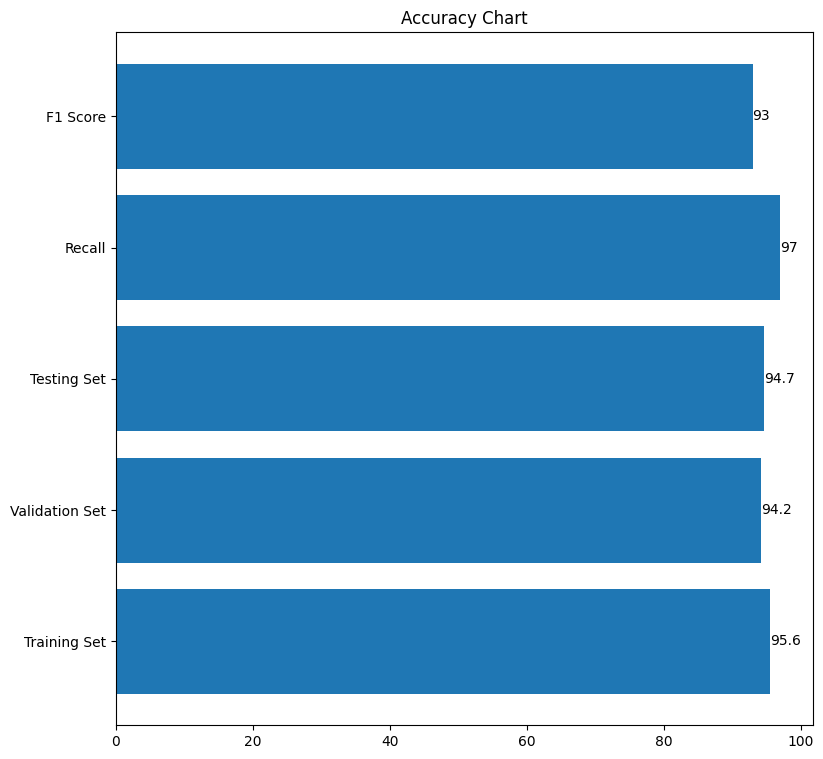

In [17]:
import matplotlib.pyplot as plt
# create dataset
df = pd.DataFrame ({
        'Group':  ['Training Set', 'Validation Set', 'Testing Set', 'Recall', 'F1 Score'],
})
fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(y=df.Group, width=df.Value);
ax.set_title('Accuracy Chart');
for bars in ax.containers:
    ax.bar_label(bars)